In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-gan-competition/shard_02/data.jsonl
/kaggle/input/test-gan-competition/shard_45/data.jsonl
/kaggle/input/test-gan-competition/shard_09/data.jsonl
/kaggle/input/test-gan-competition/shard_37/data.jsonl
/kaggle/input/test-gan-competition/shard_35/data.jsonl
/kaggle/input/test-gan-competition/shard_15/data.jsonl
/kaggle/input/test-gan-competition/shard_31/data.jsonl
/kaggle/input/test-gan-competition/shard_50/data.jsonl
/kaggle/input/test-gan-competition/shard_20/data.jsonl
/kaggle/input/test-gan-competition/shard_25/data.jsonl
/kaggle/input/test-gan-competition/shard_46/data.jsonl
/kaggle/input/test-gan-competition/shard_39/data.jsonl
/kaggle/input/test-gan-competition/shard_40/data.jsonl
/kaggle/input/test-gan-competition/shard_44/data.jsonl
/kaggle/input/test-gan-competition/shard_33/data.jsonl
/kaggle/input/test-gan-competition/shard_59/data.jsonl
/kaggle/input/test-gan-competition/shard_53/data.jsonl
/kaggle/input/test-gan-competition/shard_54/data.jsonl
/kaggle/in

# Imports

In [2]:
import os
import io
import json
import base64
import math
import random
import re
import traceback
from pathlib import Path
from typing import Optional

import numpy as np
from PIL import Image, ImageOps, ExifTags
from IPython.display import display

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
import pandas as pd
from tqdm.auto import tqdm

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print("Torch:", torch.__version__, "Torchvision:", torchvision.__version__)


Device: cuda
Torch: 2.6.0+cu124 Torchvision: 0.21.0+cu124


# Robust EXIF rotation, base64 extraction, alpha handling, safe open

In [3]:
EXIF_ORIENT_TAG = None
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
for k, v in ExifTags.TAGS.items():
    if v == 'Orientation':
        EXIF_ORIENT_TAG = k
        break

_b64_prefix = re.compile(r"^data:.*;base64,")
_b64_sig = re.compile(r"^(?:/9j/|iVBOR|R0lG|UklGR)")

def apply_exif_orientation_with_fallback(img: Image.Image, explicit_exif_rot=None) -> Image.Image:
    try:
        if explicit_exif_rot is not None:
            orientation = int(explicit_exif_rot)
            if orientation == 2:
                return ImageOps.mirror(img)
            if orientation == 3:
                return img.rotate(180, expand=True)
            if orientation == 4:
                return ImageOps.flip(img)
            if orientation == 5:
                return ImageOps.mirror(img.rotate(-90, expand=True))
            if orientation == 6:
                return img.rotate(-90, expand=True)
            if orientation == 7:
                return ImageOps.mirror(img.rotate(90, expand=True))
            if orientation == 8:
                return img.rotate(90, expand=True)
            return img
    except Exception:
        pass

    try:
        exif = getattr(img, "_getexif", lambda: None)()
        if not exif:
            return img
        orientation = exif.get(EXIF_ORIENT_TAG, None)
        if orientation == 2:
            return ImageOps.mirror(img)
        if orientation == 3:
            return img.rotate(180, expand=True)
        if orientation == 4:
            return ImageOps.flip(img)
        if orientation == 5:
            return ImageOps.mirror(img.rotate(-90, expand=True))
        if orientation == 6:
            return img.rotate(-90, expand=True)
        if orientation == 7:
            return ImageOps.mirror(img.rotate(90, expand=True))
        if orientation == 8:
            return img.rotate(90, expand=True)
    except Exception:
        pass
    return img

def extract_b64_pairs_from_record(rec: dict):
    img_keys = ("img_b64", "image", "image_base64", "b64", "b64_image", "data", "encoded", "img", "file")
    alpha_keys = ("alpha_b64","alpha","mask_b64","mask")

    img_b64 = None
    alpha_b64 = None
    invert_flag = False
    explicit_exif_rot = None

    if "invert" in rec:
        try:
            invert_flag = bool(rec.get("invert"))
        except Exception:
            invert_flag = False
    if "inverted" in rec:
        try:
            invert_flag = invert_flag or bool(rec.get("inverted"))
        except Exception:
            pass
    if "exif_rot" in rec:
        try:
            explicit_exif_rot = rec.get("exif_rot")
        except Exception:
            explicit_exif_rot = None

    for k in img_keys:
        if k in rec and isinstance(rec[k], str) and len(rec[k].strip()) > 50:
            s = rec[k].strip()
            if s.lower().startswith("data:") and "," in s:
                s = s.split(",",1)[1]
            img_b64 = s
            break

    if img_b64 is None:
        for v in rec.values():
            if isinstance(v, str) and len(v) > 100 and (v.strip().startswith("/9j/") or v.strip().startswith("iVBOR") or "base64" in v):
                s = v.strip()
                if s.lower().startswith("data:") and "," in s:
                    s = s.split(",",1)[1]
                img_b64 = s
                break

    for k in alpha_keys:
        if k in rec and isinstance(rec[k], str) and len(rec[k].strip()) > 50:
            s = rec[k].strip()
            if s.lower().startswith("data:") and "," in s:
                s = s.split(",",1)[1]
            alpha_b64 = s
            break

    return img_b64, alpha_b64, invert_flag, explicit_exif_rot

def open_image_with_optional_alpha_and_invert(img_b64, alpha_b64=None, invert_flag=False, exif_rot=None):
    img_bytes = base64.b64decode(img_b64)
    img = Image.open(io.BytesIO(img_bytes))
    try:
        if img.mode not in ("RGBA","RGB","L","LA","P"):
            img = img.convert("RGBA")
    except Exception:
        img = img.convert("RGBA")

    img = apply_exif_orientation_with_fallback(img, explicit_exif_rot=exif_rot)

    if alpha_b64:
        try:
            alpha_bytes = base64.b64decode(alpha_b64)
            alpha_img = Image.open(io.BytesIO(alpha_bytes)).convert("L")
            if img.mode != "RGBA":
                img = img.convert("RGBA")
            if alpha_img.size != img.size:
                alpha_img = alpha_img.resize(img.size, Image.BILINEAR)
            r,g,b,a = img.convert("RGBA").split()
            img = Image.merge("RGBA", (r,g,b, alpha_img))
        except Exception:
            pass

    if invert_flag:
        try:
            if img.mode == "RGBA":
                rgb = img.convert("RGB")
                inv = ImageOps.invert(rgb)
                inv.putalpha(img.split()[-1])
                img = inv
            else:
                img = ImageOps.invert(img.convert("RGB"))
        except Exception:
            pass

    return img

def safe_open_record_image(rec: dict):
    try:
        img_b64, alpha_b64, invert_flag, exif_rot = extract_b64_pairs_from_record(rec)
        if not img_b64:
            raise ValueError(f"No image base64 found in record keys: {list(rec.keys())}")
        img = open_image_with_optional_alpha_and_invert(img_b64, alpha_b64=alpha_b64, invert_flag=invert_flag, exif_rot=exif_rot)
        return img, None
    except Exception as e:
        tb = traceback.format_exc()
        short = f"Error opening record id={rec.get('id','?')}: {str(e)}"
        print(short)
        white = Image.new("RGB", (32,32), (255,255,255))
        return white, short


# Preprocess to 32x32 and robust dataset class

In [4]:
def preprocess_to_32_safe(img: Image.Image) -> torch.Tensor:
    try:
        if img.mode == "RGBA":
            bg = Image.new("RGB", img.size, (255,255,255))
            bg.paste(img, mask=img.split()[3])
            img = bg
        elif img.mode in ("LA",):
            bg = Image.new("L", img.size, 255)
            bg.paste(img, mask=img.split()[1])
            img = bg.convert("RGB")
        elif img.mode in ("L",):
            img = img.convert("RGB")
        elif img.mode == "P":
            img = img.convert("RGB")
        else:
            img = img.convert("RGB")
    except Exception:
        img = img.convert("RGB")

    img = img.resize((32,32), Image.BICUBIC)
    arr = np.array(img).astype(np.float32) / 255.0
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)
    if arr.shape[2] == 4:
        arr = arr[:,:,:3]
    arr = np.transpose(arr, (2,0,1))
    tensor = torch.from_numpy(arr)
    tensor = tensor * 2.0 - 1.0
    return tensor

class JSONLImageDatasetRobust(Dataset):
    def __init__(self, jsonl_paths, max_records: Optional[int]=None):
        self.records = []
        for p in jsonl_paths:
            p = str(p)
            with open(p, 'r', encoding='utf-8') as fh:
                for line in fh:
                    if not line.strip():
                        continue
                    try:
                        rec = json.loads(line)
                    except Exception:
                        continue
                    self.records.append(rec)
                    if max_records and len(self.records) >= max_records:
                        break
            if max_records and len(self.records) >= max_records:
                break
        print(f"[RobustDataset] loaded {len(self.records)} records from {len(jsonl_paths)} shard files.")

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        rec = self.records[idx]
        img, debug_err = safe_open_record_image(rec)
        tensor = preprocess_to_32_safe(img)
        return tensor


# Discover Shards

Found shard count: 60
  /kaggle/input/test-gan-competition/shard_00/data.jsonl
  /kaggle/input/test-gan-competition/shard_01/data.jsonl
  /kaggle/input/test-gan-competition/shard_02/data.jsonl
  /kaggle/input/test-gan-competition/shard_03/data.jsonl
  /kaggle/input/test-gan-competition/shard_04/data.jsonl
  /kaggle/input/test-gan-competition/shard_05/data.jsonl
  /kaggle/input/test-gan-competition/shard_06/data.jsonl
  /kaggle/input/test-gan-competition/shard_07/data.jsonl
  /kaggle/input/test-gan-competition/shard_08/data.jsonl
  /kaggle/input/test-gan-competition/shard_09/data.jsonl
[RobustDataset] loaded 60000 records from 60 shard files.
Dataset length: 60000
Error opening record id=train-002624: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-002288: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record

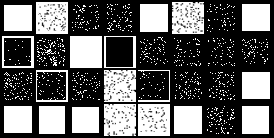

In [5]:
root = Path("/kaggle/input/test-gan-competition")
shard_paths = sorted([str(p) for p in root.rglob("data.jsonl")])
print("Found shard count:", len(shard_paths))
if len(shard_paths) == 0:
    raise FileNotFoundError("No data.jsonl found under /kaggle/input/test-gan-competition. Check path and dataset.")

for p in shard_paths[:10]:
    print(" ", p)

# Create dataset. For a quick debug set max_records small (e.g., 2000). For full training set None.
max_records = None
ds = JSONLImageDatasetRobust(shard_paths, max_records=max_records)

# quick DataLoader preview
dl = DataLoader(ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
print("Dataset length:", len(ds))
if len(ds) > 0:
    batch = next(iter(dl))
    print("Batch shape:", batch.shape)
    # denormalize and display grid
    b = batch.clone()
    b = (b + 1.0)/2.0
    grid = utils.make_grid(b[:32], nrow=8, padding=2)
    npimg = grid.permute(1,2,0).cpu().numpy()
    display(Image.fromarray((npimg*255).astype(np.uint8)))


# DCGAN generator and discriminator definitions (32x32)

In [6]:
nz = 128
ngf = 128
ndf = 128
nc = 3

class DCGANGenerator(nn.Module):
    def __init__(self, nz=128, ngf=128, nc=3):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),  # 4x4
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  # 32x32
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z.view(z.size(0), z.size(1), 1, 1))

class DCGANDiscriminator(nn.Module):
    def __init__(self, nc=3, ndf=128):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),  # 16x16
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),  # 4x4
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False),  # 1x1
        )

    def forward(self, x):
        out = self.main(x)
        return out.view(-1, 1).squeeze(1)


# Training loop for DCGAN with prints and checkpoint saving

In [7]:
def train_dcgan(dataset: Dataset,
                epochs=20,
                batch_size=128,
                nz=128,
                lr=2e-4,
                betas=(0.5, 0.999),
                save_dir="/kaggle/working/models_dcgan",
                sample_every=1000,
                device=device):
    os.makedirs(save_dir, exist_ok=True)
    dl = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    G = DCGANGenerator(nz=nz, ngf=ngf, nc=nc).to(device)
    D = DCGANDiscriminator(nc=nc, ndf=ndf).to(device)

    optG = optim.Adam(G.parameters(), lr=lr, betas=betas)
    optD = optim.Adam(D.parameters(), lr=lr, betas=betas)
    bce = nn.BCEWithLogitsLoss()

    fixed_noise = torch.randn(64, nz, device=device)
    iters = 0

    print(f"Training for {epochs} epochs. Steps per epoch: {len(dl)}")
    for epoch in range(1, epochs+1):
        G.train(); D.train()
        pbar = tqdm(dl, desc=f"Epoch {epoch}/{epochs}")
        for real in pbar:
            real = real.to(device)
            bs = real.size(0)
            # Train D
            D.zero_grad()
            label_real = torch.full((bs,), 0.9, device=device)
            out_real = D(real)
            loss_real = bce(out_real, label_real)

            noise = torch.randn(bs, nz, device=device)
            fake = G(noise)
            out_fake = D(fake.detach())
            label_fake = torch.zeros((bs,), device=device)
            loss_fake = bce(out_fake, label_fake)
            lossD = (loss_real + loss_fake) * 0.5
            lossD.backward()
            optD.step()

            # Train G
            G.zero_grad()
            label_gen = torch.ones((bs,), device=device)
            out_fake_forG = D(fake)
            lossG = bce(out_fake_forG, label_gen)
            lossG.backward()
            optG.step()

            iters += 1
            pbar.set_postfix(dict(lossD=float(lossD.item()), lossG=float(lossG.item())))

            if iters % sample_every == 0:
                G.eval()
                with torch.no_grad():
                    samples = G(fixed_noise).cpu()
                grid = utils.make_grid((samples+1)/2, nrow=8, padding=2)
                torchvision.utils.save_image(grid, os.path.join(save_dir, f"samples_iter_{iters}.png"))
                G.train()

        ckpt = {"G": G.state_dict(), "D": D.state_dict(), "optG": optG.state_dict(), "optD": optD.state_dict(), "epoch": epoch, "nz": nz}
        torch.save(ckpt, os.path.join(save_dir, f"dcgan_epoch_{epoch}.pt"))
        print(f"Saved checkpoint: {os.path.join(save_dir, f'dcgan_epoch_{epoch}.pt')}")

    return G, D

# Example call (adjust epochs depending on compute). For quick tests set epochs=1.
G, D = train_dcgan(ds, epochs=12, batch_size=256 if not torch.cuda.is_available() else 128, nz=nz, lr=2e-4)


Training for 12 epochs. Steps per epoch: 469
Error opening record id=train-028546: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']


Epoch 1/12:   0%|          | 0/469 [00:00<?, ?it/s]

Error opening record id=train-043522: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']Error opening record id=train-008793: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

Error opening record id=train-057233: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-005705: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img64', 'alpha_b64']
Error opening record id=train-025159: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']Error opening record id=train-016981: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

Error opening record id=train-004345: No image base64 found in record keys: ['

Epoch 2/12:   0%|          | 0/469 [00:00<?, ?it/s]

Error opening record id=train-008793: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-012792: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-010735: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-050077: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']Error opening record id=train-019147: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

Error opening record id=train-057868: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-019609: No image base64 found in record keys: 

Epoch 3/12:   0%|          | 0/469 [00:00<?, ?it/s]

Error opening record id=train-024408: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-008793: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-032163: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-030870: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img64', 'alpha_b64']
Error opening record id=train-038693: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-019609: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-023727: No image base64 found in record keys: ['

Epoch 4/12:   0%|          | 0/469 [00:00<?, ?it/s]


Error opening record id=train-024492: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

Error opening record id=train-029123: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']Error opening record id=train-031378: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-005810: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-021147: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-026936: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-009106: No image base64 found in record keys:

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7824d71823e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^

Error opening record id=train-009482: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

^

^^^^^^^^^^

Error opening record id=train-019074: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

^

^^^
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7824d71823e0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7824d71823e0>
    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive():
        ^^ ^ ^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can on

Error opening record id=train-031212: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^

Error opening record id=train-018451: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']


^^^^^^^^
AssertionError: 

Error opening record id=train-001277: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

can only test a child process

Error opening record id=train-026338: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-023288: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-059152: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-006985: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-053537: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-033728: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-054985: No image base64 found in record keys: 

Epoch 5/12:   0%|          | 0/469 [00:00<?, ?it/s]

Error opening record id=train-021196: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-025933: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-013327: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-012407: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']Error opening record id=train-002137: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

Error opening record id=train-051087: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-051071: No image base64 found in record keys: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7824d71823e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Error opening record id=train-054888: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

AssertionError

: can only test a child process
Exception ignored in: 

Error opening record id=train-022446: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

<function _MultiProcessingDataLoaderIter.__del__ at 0x7824d71823e0>


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7824d71823e0>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers()  
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
^ ^ ^ ^ ^ ^^ ^ ^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^^
    File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
       assert self._parent_pid 

Error opening record id=train-033310: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

^

^^^^

Error opening record id=train-022370: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

AssertionError: can only test a child process


Error opening record id=train-057233: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7824d71823e0>


Error opening record id=train-020294: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

Traceback (most recent call last):


  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       

Error opening record id=train-036446: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']


^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive


Error opening record id=train-029034: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

assert self._parent_pid == os.getpid(), 'can only test a child process'
       

Error opening record id=train-029285: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Error opening record id=train-016157: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-041830: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-012052: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-038285: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-022447: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-006706: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-009940: No image base64 found in record keys: 

Epoch 6/12:   0%|          | 0/469 [00:00<?, ?it/s]

Error opening record id=train-007071: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-043925: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-022527: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-003564: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-009957: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-017184: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-047944: No image base64 found in record keys: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7824d71823e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7824d71823e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7824d71823e0>

Error opening record id=train-010466: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

   ^^

Error opening record id=train-006285: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

^

^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^

Error opening record id=train-046304: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

^^

^^^^^^^^

Error opening record id=train-059610: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

^

^^

Error opening record id=train-041529: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']


^^^^^^^^^^^^^^
AssertionError: can only test a child process


Error opening record id=train-001093: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-053795: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-056488: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-041124: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-043522: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-058214: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-012407: No image base64 found in record keys: 

Epoch 7/12:   0%|          | 0/469 [00:00<?, ?it/s]

Error opening record id=train-010812: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-012795: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']Error opening record id=train-031037: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img64', 'alpha_b64']

Error opening record id=train-041741: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img64', 'alpha_b64']
Error opening record id=train-015138: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']


Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7824d71823e0>
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__


Error opening record id=train-031923: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7824d71823e0>
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers



Error opening record id=train-012946: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

    Traceback (most recent call last):


if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers()   
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
 ^    ^if w.is_alive():^
^ ^ ^^ Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7824d71823e0> 
^ ^Traceback (most recent call last):
 ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
 
^      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^self._shutdown_workers()^    
^assert self._parent_pid == os.getpid(), 'can only test a child process'^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^     ^if w.is_alive(): ^
 ^  ^  ^  ^  
     File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
       ^assert self._parent_pid == os.

Error opening record id=train-031036: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-030483: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-012373: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-030288: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-021147: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']Error opening record id=train-035977: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

Error opening record id=train-043658: No image base64 found in record keys: 

Epoch 8/12:   0%|          | 0/469 [00:00<?, ?it/s]

Error opening record id=train-058317: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-041058: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']Error opening record id=train-020294: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

Error opening record id=train-037147: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']Error opening record id=train-002829: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

Error opening record id=train-041741: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img64', 'alpha_b64']
Error opening record id=train-051106: No image base64 found in record keys: ['

Epoch 9/12:   0%|          | 0/469 [00:00<?, ?it/s]

Error opening record id=train-037309: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-010600: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-050520: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-030332: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-019849: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-006774: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-031212: No image base64 found in record keys: 

Epoch 10/12:   0%|          | 0/469 [00:00<?, ?it/s]

Error opening record id=train-000164: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']Error opening record id=train-056839: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

Error opening record id=train-008609: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-052381: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']Error opening record id=train-040461: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

Error opening record id=train-027175: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-016832: No image base64 found in record keys: 

Epoch 11/12:   0%|          | 0/469 [00:00<?, ?it/s]

Error opening record id=train-011487: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-028307: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-010910: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']Error opening record id=train-033899: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

Error opening record id=train-052283: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-048379: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-044927: No image base64 found in record keys: 

Epoch 12/12:   0%|          | 0/469 [00:00<?, ?it/s]

Error opening record id=train-047764: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-053367: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-036788: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-019849: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']
Error opening record id=train-027444: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']Error opening record id=train-028576: No image base64 found in record keys: ['id', 'mode', 'size', 'exif_rot', 'invert', 'label', 'img_b64', 'alpha_b64']

Error opening record id=train-022399: No image base64 found in record keys: 

In [8]:
def generate_and_save_samples(G: nn.Module, n_samples=1000, nz=128, batch_size=128, out_dir="/kaggle/working/generated_images"):
    os.makedirs(out_dir, exist_ok=True)
    G.eval()
    all_imgs = []
    n_batches = math.ceil(n_samples / batch_size)
    with torch.no_grad():
        for i in range(n_batches):
            cur = min(batch_size, n_samples - i*batch_size)
            noise = torch.randn(cur, nz, device=device)
            imgs = G(noise).cpu()
            all_imgs.append(imgs)
    all_imgs = torch.cat(all_imgs, dim=0)[:n_samples]
    for i, t in enumerate(tqdm(all_imgs, desc="Saving generated images")):
        arr = ((t + 1.0) / 2.0 * 255.0).clamp(0,255).permute(1,2,0).numpy().astype(np.uint8)
        pil = Image.fromarray(arr)
        pil.save(os.path.join(out_dir, f"dig-{i:06d}.png"))
    print(f"Saved {n_samples} images to {out_dir}")
    return all_imgs

generated_tensor = generate_and_save_samples(G, n_samples=1000, nz=nz, batch_size=128)


Saving generated images:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved 1000 images to /kaggle/working/generated_images


# Robust Inception-V3 loader + feature extraction 

In [9]:
import traceback
from torchvision.models import inception_v3


def load_inception_model(device):
    last_err = None
    try:
        try:
            from torchvision.models import Inception_V3_Weights
            weights = Inception_V3_Weights.DEFAULT
            model = inception_v3(weights=weights, aux_logits=False, transform_input=False)
            print("[Inception] loaded using Inception_V3_Weights.DEFAULT with aux_logits=False")
            return model
        except Exception as e_modern:
            last_err = e_modern
            # fallback: some torchvision builds require aux_logits=True when loading pretrained weights
            print("[Inception] modern weights API failed or not available; falling back to pretrained=True with aux_logits=True. Error:", e_modern)

        # fallback for older torchvision: use pretrained=True and aux_logits=True (builder expects aux=True for those weights)
        model = inception_v3(pretrained=True, aux_logits=True, transform_input=False)
        print("[Inception] loaded using pretrained=True with aux_logits=True (fallback).")
        return model

    except Exception as e:
        tb = traceback.format_exc()
        raise RuntimeError("Failed to load Inception-V3 pretrained weights. Attempted modern and fallback methods.\n"
                           f"Last error: {e}\nTrace:\n{tb}")

# Feature extractor class using the loaded model
class InceptionV3FeatureExtractorRobust(nn.Module):
    def __init__(self, device=device):
        super().__init__()
        self.device = device
        self.model = load_inception_model(device)
        # Freeze params
        for p in self.model.parameters():
            p.requires_grad = False
        self.model.eval()
        self.model.to(self.device)
        # If model was loaded with aux_logits=True, it's okay: the internal blocks we use below still exist.

    def forward(self, x):
        # expects x in [-1,1] shape (B,3,32,32)
        x = (x + 1.0) / 2.0  # -> [0,1]
        x = torch.nn.functional.interpolate(x.to(self.device), size=(299,299), mode='bilinear', align_corners=False)
        mean = torch.tensor([0.485,0.456,0.406], device=self.device).view(1,3,1,1)
        std  = torch.tensor([0.229,0.224,0.225], device=self.device).view(1,3,1,1)
        x = (x - mean) / std

        # forward through inception until avgpool (works whether aux_logits True or False)
        x = self.model.Conv2d_1a_3x3(x)
        x = self.model.Conv2d_2a_3x3(x)
        x = self.model.Conv2d_2b_3x3(x)
        x = self.model.maxpool1(x)
        x = self.model.Conv2d_3b_1x1(x)
        x = self.model.Conv2d_4a_3x3(x)
        x = self.model.maxpool2(x)
        x = self.model.Mixed_5b(x)
        x = self.model.Mixed_5c(x)
        x = self.model.Mixed_5d(x)
        x = self.model.Mixed_6a(x)
        x = self.model.Mixed_6b(x)
        x = self.model.Mixed_6c(x)
        x = self.model.Mixed_6d(x)
        x = self.model.Mixed_6e(x)
        x = self.model.Mixed_7a(x)
        x = self.model.Mixed_7b(x)
        x = self.model.Mixed_7c(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        return x

# Instantiate feature extractor (this will load weights)
print("Loading Inception-V3 (this may take a moment)...")
feat_ext = InceptionV3FeatureExtractorRobust(device=device)
print("Inception-V3 loaded and ready on device:", device)


Loading Inception-V3 (this may take a moment)...
[Inception] modern weights API failed or not available; falling back to pretrained=True with aux_logits=True. Error: The parameter 'aux_logits' expected value True but got False instead.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 58.3MB/s] 


[Inception] loaded using pretrained=True with aux_logits=True (fallback).
Inception-V3 loaded and ready on device: cuda


 # Submission File

In [10]:
import pandas as pd
import numpy as np
import torch

def make_submission_csv(feature_extractor, images_tensor, out_csv="/kaggle/working/submission.csv", batch_size=64):
    """
    feature_extractor: nn.Module that outputs (B, 2048) pool3 features
    images_tensor: (N,3,32,32) float32 in [-1,1]
    """

    assert images_tensor.ndim == 4, "images_tensor must be (N,3,32,32)"
    N = images_tensor.shape[0]
    print(f"[make_submission_csv] Extracting features for {N} images...")

    rows = []
    feature_extractor.eval()

    with torch.no_grad():
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            batch = images_tensor[start:end].to(device)

            # Forward pass through Inception feature extractor
            feats = feature_extractor(batch)     # shape (B, 2048)
            feats = feats.cpu().numpy()

            # Build rows
            for i, f in enumerate(feats):
                global_idx = start + i
                rows.append([f"dig-{global_idx:06d}"] + f.tolist())

            print(f"Processed {end}/{N} images", end="\r")

    print("\nWriting CSV...")

    # Build DataFrame
    cols = ["id"] + [f"f{j}" for j in range(2048)]
    df = pd.DataFrame(rows, columns=cols)

    df.to_csv(out_csv, index=False, float_format="%.6f")
    print(f"[make_submission_csv] Saved: {out_csv}")

    return df


if 'generated_tensor' in globals():
    print("Found `generated_tensor` — extracting features & writing submission.csv")

try:
    df = make_submission_csv(
        feature_extractor = feat_ext,
        images_tensor = generated_tensor,
        out_csv = "/kaggle/working/submission.csv",
        batch_size = 64
    )
    print("submission.csv written successfully!")
except Exception as e:
    print("Error during CSV creation:", e)
    print(traceback.format_exc())


Found `generated_tensor` — extracting features & writing submission.csv
[make_submission_csv] Extracting features for 1000 images...
Processed 1000/1000 images
Writing CSV...
[make_submission_csv] Saved: /kaggle/working/submission.csv
submission.csv written successfully!
